In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
# from scipy.misc import imread
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_validate

In [2]:
boston = datasets.load_boston()
X = boston.data
Y = boston.target

In [16]:
# Looking at the features of the boston data set
df = pd.DataFrame(X)
df.columns = boston.feature_names
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [21]:
# Labels (Price of houses)
df = pd.DataFrame(Y)
df.columns = ["PRICE"]
df.describe()

,PRICE
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [7]:
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data = imp.fit_transform(X)

# Log transformation
data = np.log(X)
labels = np.log(Y)

# Change -inf to 0 again
data[data==-np.inf]=0

In [8]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([ 0.70011254,  0.85608933,  0.90358204,  0.93421674,  0.95491797,
        0.97240646,  0.98789775,  0.99431238,  0.9978208 ,  0.99883683,
        0.99944554,  1.        ,  1.        ])

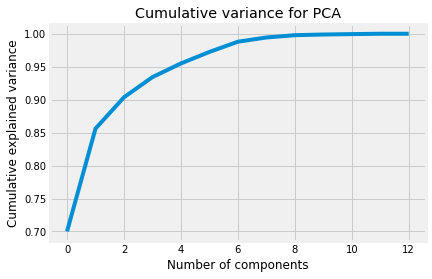

In [9]:
# plot the variances of each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative variance for PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

explained variance ratio (first 3 components): [ 0.80581464  0.16305085  0.02134869]


Text(0.5,0,'Principle Component 3')

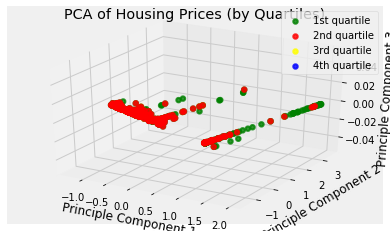

In [55]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(whiten=True,n_components=3)
X_r = pca.fit(X).transform(X)

target_names = ["1st quartile","2nd quartile","3rd quartile","4th quartile"]
y = Y

print('explained variance ratio (first 3 components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
colors = ['green', 'red', 'yellow', 'blue']
lw = 2

ax = fig.add_subplot(111, projection='3d')
for color, i, target_name in zip(colors, [0, 25, 50, 75], target_names):
    ax.scatter(X_r[y > np.percentile(y,i), 0], X_r[y > np.percentile(y,i), 1], color=color, alpha=.8, lw=lw, label=target_name)
ax.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title('PCA of Housing Prices (by Quartiles)')
ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")
ax.set_zlabel("Principle Component 3")

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import Imputer

lin = linear_model.LinearRegression()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imp.fit_transform(X)

data = np.log(X)
labels = np.log(labels)

data[data==-np.inf]=0


In [11]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([ 0.70011254,  0.85608933,  0.90358204,  0.93421674,  0.95491797,
        0.97240646,  0.98789775,  0.99431238,  0.9978208 ,  0.99883683,
        0.99944554,  1.        ,  1.        ])

In [44]:
pca = PCA(whiten=True, n_components=8)
pca_data = pca.fit_transform(X)
cv_results = cross_validate(lin, X, Y, cv=10, scoring='neg_mean_squared_error')
pca_cv_results = cross_validate(lin, pca_data, Y, cv=10, scoring='neg_mean_squared_error')

In [45]:
from functools import reduce

def get_cv_results(cv_results):
    test_score = cv_results['test_score']
    train_score = cv_results['train_score']
    fit_time = cv_results['fit_time']

    print("mean test score: ", reduce(lambda x, y: abs(x)+abs(y), test_score)/len(test_score))
    print("mean train score: ", reduce(lambda x, y: abs(x)+abs(y), train_score)/len(train_score))
    print("mean fit time: ", reduce(lambda x, y: abs(x)+abs(y), fit_time)/len(fit_time))

In [46]:
get_cv_results(cv_results)

mean test score:  34.7630915054
mean train score:  21.400562347
mean fit time:  0.0011777639389


In [47]:
get_cv_results(pca_cv_results)

mean test score:  38.9717713057
mean train score:  33.4079330307
mean fit time:  0.00140609741211
